# Predicting academic achievement from inattention (SNAP) - preparation

Arvid Lundervold, 25-Sep-2017

A.J. Lundervold, T. Bøe, A. Lundervold. *Inattention in primary school is not good for your future school achievement - a pattern classification study*. In rev.

*Objective.* Inattention in childhood has been associated with academic problems later in life. The contribution of specific aspects of inattentive behaviour is, however, less known. We investigated the importance of primary teacher reports on nine aspects of inattentive behaviour in predicting future academic achievement.<br>
*Methods*. Primary school teachers of 2491 children (7 - 9 years) rated nine items reflecting different aspects of inattentive behaviour. Academic achievement scores were available from an official school register about ten years later. All scores were at a categorical level. Two multivariate statistical methods (in R), a multinominal logistic regression analysis and a Classification and Regression Trees (CART) analysis, were included to predict high school academic achievement from the nine inattention items, gender and their primary school class level (grade) when evaluated by their teachers
(2nd to 4th grade, 7 - 9 years).<br>
*Results.* Problems related to sustained attention and distractibility were found to be important predictors of low level of academic achievement in high school. Overall, inattention was rated as more severe in boys, who also obtained lower achievement scores at high school than girls. However, if reported to have no problems related to sustained attention and distractibility in the 4th primary school class level, the percentage of boys with the highest level of the achievement score was as high as in girls (> 40%).<br>
*Conclusion.* Primary school teachers’ reports of problems related to sustained attention and distractibility were strong predictors of low academic achievement in high school. Identification and follow-up procedures of primary school children showing this pattern of inattentive behaviour should be prioritised to prevent future academic and occupational failure.

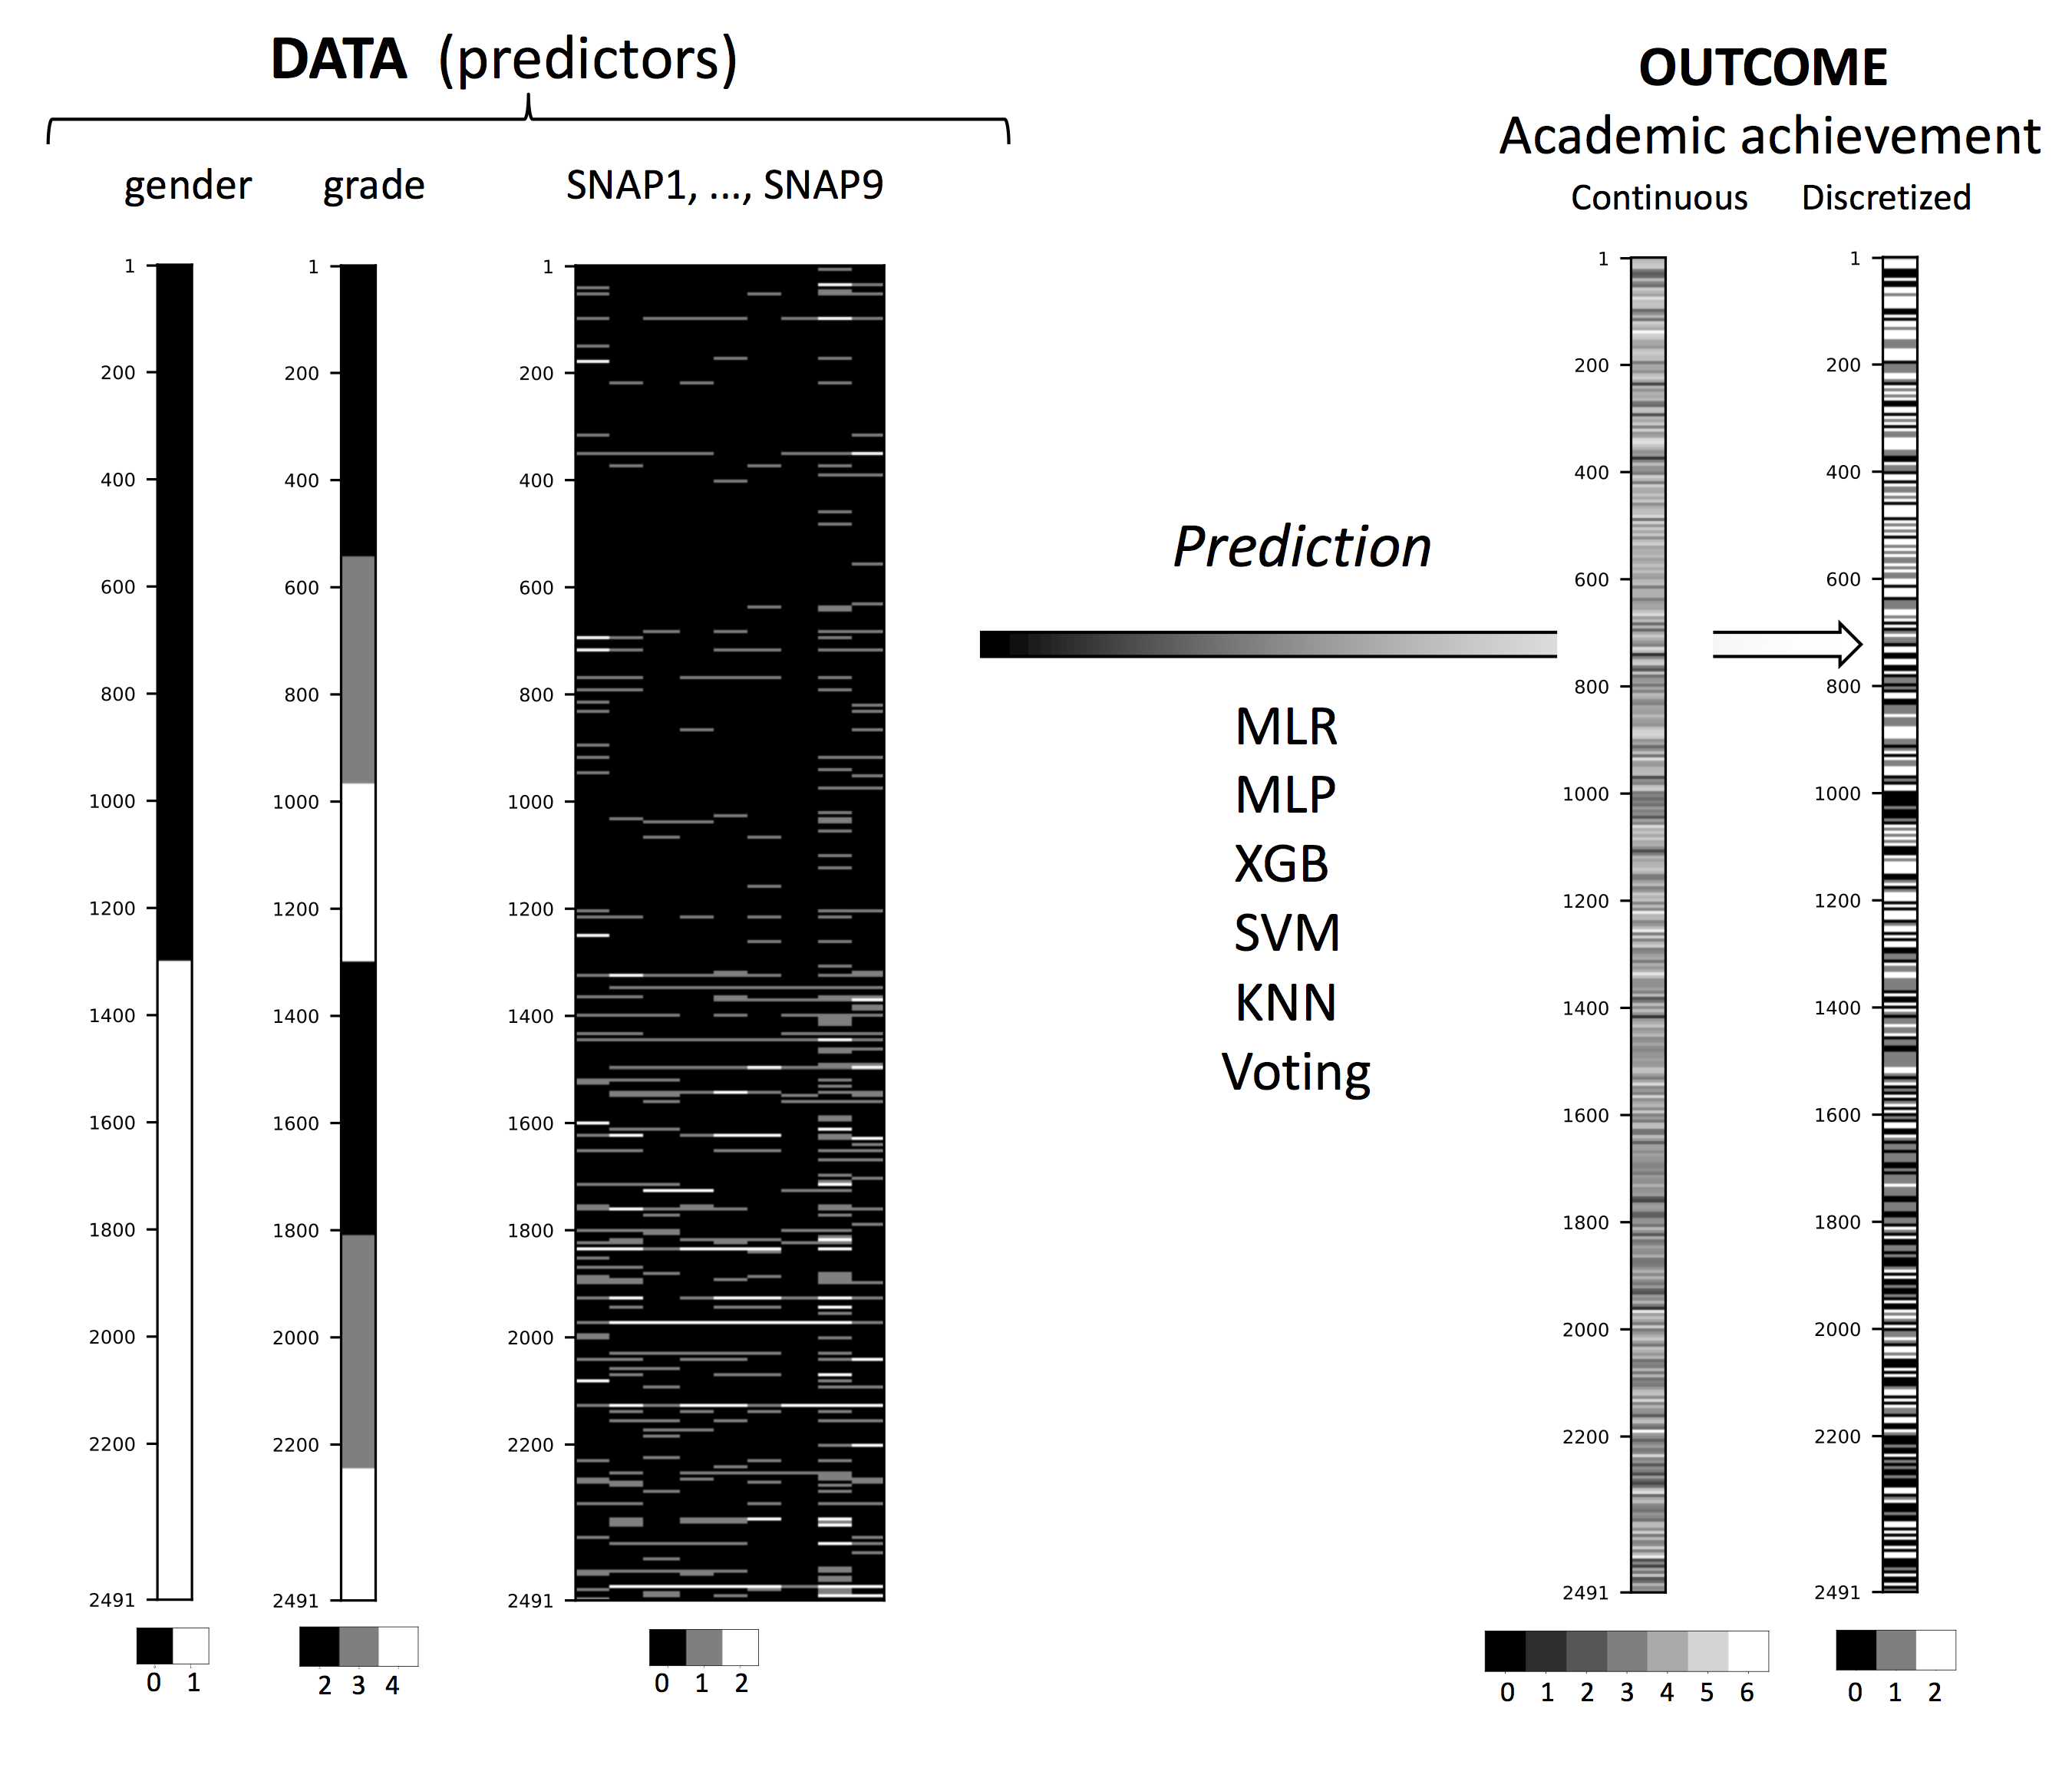

In [90]:
from IPython.display import Image
Image("../images/Data_to_classes_notebook_pptx.png")

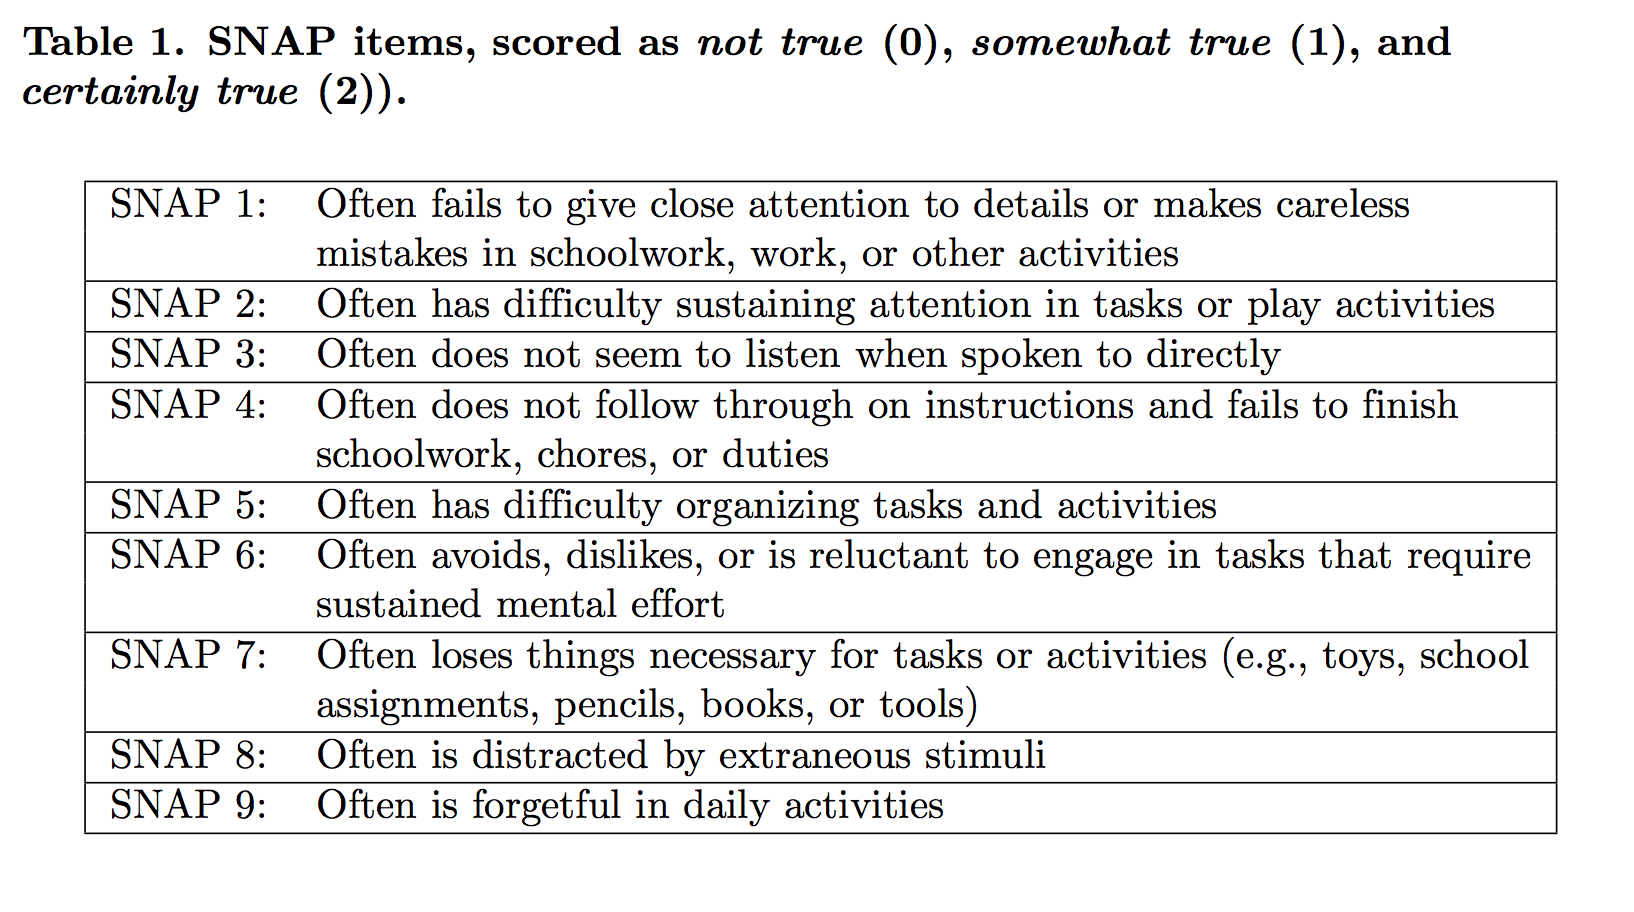

In [39]:
from IPython.display import Image
Image("../images/snap.png")

## Prepare

In [40]:
%matplotlib inline

import os
import os.path as op
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import seaborn as sns
import math
import csv
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz 
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from io import StringIO
import statsmodels.formula.api as smf

# conda install r-base (package=3.3.2)
# conda install r-base=3.3.2   (rpy2 not working for r-base 3.4.1)
# conda install rpy2
from rpy2.robjects import pandas2ri, r # fpr reading .sav files via rpy2 and r-foreign
# from boruta import BorutaPy

import nilearn
import sklearn
import matplotlib
import pydicom  # pip install git+https://github.com/pydicom/pydicom.git
import xgboost as xgb
import statsmodels as sm
import rpy2
#import boruta

print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('nibabel: %s' % nib.__version__)
print('scipy: %s' % scipy.__version__)
print('nilearn: %s' % nilearn.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('pydicom: %s' % pydicom.__version__)
print('seaborn: %s' % sns.__version__)
print('xgboost: %s' % xgb.__version__)
print('graphviz: %s' % graphviz.__version__)
print('statsmodels: %s' % sm.__version__)
print('rpy2: %s' % rpy2.__version__)

numpy: 1.12.1
pandas: 0.20.3
nibabel: 2.1.0
scipy: 0.19.1
nilearn: 0.3.1
matplotlib: 2.0.2
sklearn: 0.19.0
pydicom: 1.0.0a1
seaborn: 0.8.1
xgboost: 0.6
graphviz: 0.7.1
statsmodels: 0.8.0
rpy2: 2.8.5


In [41]:
# Relevant files
# The original SPSS file as provided to AJL is
# 'inattention_Astri_94_96_new_grades_updated.sav'
# and being edited and reduced by AJL to 'inattention_Arvid_new.sav'
# Import data stored in the SPSS format
fn = "/Users/arvid/Dropbox/Arvid_inattention/data2/inattention_Arvid_new.sav"
fn_orig = "/Users/arvid/Dropbox/Arvid_inattention/data2/inattention_Astri_94_96_new_grades_updated.sav"

In [42]:
# > library(foreign)
# > fn = "/Users/arvid/Dropbox/Arvid_inattention/data2/inattention_Arvid_new.sav"
# > dataset = read.spss(fn, to.data.frame=TRUE)

# conda install r-base=3.3.2   (rpy2 not working for r-base 3.4.1)
# from rpy2.robjects import pandas2ri, r
D = r('foreign::read.spss("%s", to.data.frame=TRUE)' % fn_orig)

dfSPSS = pandas2ri.ri2py(D)
print(dfSPSS.columns)
print(dfSPSS.shape)
dfSPSS.head()

/Users/arvid/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: re-encoding from latin1

  warnings.warn(x, RRuntimeWarning)


Index(['idr1', 'idr2', 'idr3', 'DB_ID', 'gender', 'y_4_userid', 'grade',
       's3_75', 's3_76', 's3_77',
       ...
       'filter', 'filter_.', 'IOP_dikotom', 'ID_dikotom', 'IV_dikotom',
       'KIG_dikotom', 'deltatt_dikotom', 'fritak_dikotom',
       'academic_achievement', 'ac_ach_cat'],
      dtype='object', length=496)
(10870, 496)


,idr1,idr2,idr3,DB_ID,gender,y_4_userid,grade,s3_75,s3_76,s3_77,...,filter,filter_.,IOP_dikotom,ID_dikotom,IV_dikotom,KIG_dikotom,deltatt_dikotom,fritak_dikotom,academic_achievement,ac_ach_cat
1,NaN,NaN,NaN,NaN,Jente,ID187756 ...,NaN,Stemmer ikke,Stemmer ikke,Stemmer ikke,...,NaN,Not Selected,IOP,Ikke deltatt,Ikke vurdert,Karakter ikke gitt,Deltatt,Fritak,2.857143,1.0
2,NaN,NaN,NaN,NaN,Jente,ID187930 ...,NaN,Stemmer ikke,Stemmer ikke,Stemmer ikke,...,NaN,Not Selected,IOP,Ikke deltatt,Ikke vurdert,Karakter ikke gitt,Deltatt,Fritak,NaN,NaN
3,NaN,NaN,NaN,NaN,Jente,ID194509 ...,NaN,Stemmer ikke,Stemmer ikke,Stemmer ikke,...,NaN,Not Selected,IOP,Ikke deltatt,Ikke vurdert,Karakter ikke gitt,Deltatt,Fritak,3.000000,1.0
4,NaN,NaN,NaN,NaN,Jente,ID198767 ...,NaN,Stemmer ikke,Stemmer ikke,Stemmer ikke,...,NaN,Not Selected,IOP,Ikke deltatt,Ikke vurdert,Karakter ikke gitt,Deltatt,Fritak,3.666667,2.0
5,NaN,NaN,NaN,NaN,Jente,ID200787 ...,NaN,Stemmer ikke,Stemmer ikke,Stemmer ikke,...,NaN,Not Selected,IOP,Ikke deltatt,Ikke vurdert,Karakter ikke gitt,Deltatt,Fritak,4.100000,3.0


In [43]:
list(dfSPSS.columns.values)

['idr1',
 'idr2',
 'idr3',
 'DB_ID',
 'gender',
 'y_4_userid',
 'grade',
 's3_75',
 's3_76',
 's3_77',
 's3_78',
 's3_79',
 's3_80',
 's3_81',
 's3_82',
 's3_83',
 's3_84',
 's3_85',
 's3_86',
 's3_87',
 's3_88',
 's3_89',
 's3_90',
 's3_91',
 's3_92',
 'SNAP_1_1',
 'SNAP_1_2',
 'SNAP_1_3',
 'SNAP_1_4',
 'SNAP_1_5',
 'SNAP_1_6',
 'SNAP_1_7',
 'SNAP_1_8',
 'SNAP_1_9',
 'SNAP_1_10',
 'SNAP_1_11',
 'SNAP_1_12',
 'SNAP_1_13',
 'SNAP_1_14',
 'SNAP_1_15',
 'SNAP_1_16',
 'SNAP_1_17',
 'SNAP_1_18',
 'l_sp114',
 'l_sp115',
 'l_sp116',
 'l_sp118',
 'l_sp119',
 'l_sp121',
 'pemotion',
 'pconduct',
 'phyper',
 'ppeer',
 'pprosoc',
 'pebdtot',
 'pnewimp',
 'pvlang',
 'psnapodd',
 'psnapin',
 'psnaphi',
 'temotion',
 'tconduct',
 'thyper',
 'tpeer',
 'tprosoc',
 'tebdtot',
 'tnewimp',
 'tvlang',
 'tsnapodd',
 'tsnapin',
 'tsnaphi',
 'B_S3_1',
 'B_S3_2',
 'B_S3_3',
 'B_S3_4',
 'B_S3_5',
 'B_S3_6',
 'B_S3_7',
 'B_S3_8',
 'B_S3_9',
 'B_S3_10',
 'B_S3_11',
 'B_S3_12',
 'B_S3_13',
 'B_S3_14',
 'B_S3_15',

In [44]:
# Select the subset of variables 
varlist_orig = ['gender','grade','SNAP_1_1','SNAP_1_2','SNAP_1_3','SNAP_1_4','SNAP_1_5','SNAP_1_6','SNAP_1_7','SNAP_1_8','SNAP_1_9','academic_achievement']
df = pd.DataFrame()
dfOld = dfSPSS.copy()
dfOld = dfOld[varlist_orig]
df = df.append(dfOld, ignore_index = True)
print(df.columns)
print(df.shape)

Index(['gender', 'grade', 'SNAP_1_1', 'SNAP_1_2', 'SNAP_1_3', 'SNAP_1_4',
       'SNAP_1_5', 'SNAP_1_6', 'SNAP_1_7', 'SNAP_1_8', 'SNAP_1_9',
       'academic_achievement'],
      dtype='object')
(10870, 12)


In [45]:
# Drop rows with missing observation in any of the variables
df_no_miss = pd.DataFrame()
df_no_miss = df.dropna(axis=0, how='any')
print(df_no_miss.shape)

(2491, 12)


In [46]:
df_no_miss.head()

,gender,grade,SNAP_1_1,SNAP_1_2,SNAP_1_3,SNAP_1_4,SNAP_1_5,SNAP_1_6,SNAP_1_7,SNAP_1_8,SNAP_1_9,academic_achievement
4198,Jente,2.0,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,4.666667
4199,Jente,2.0,stemmer ikke,stemmer ikke,stemmer delvis,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,3.666667
4200,Jente,2.0,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,4.142857
4201,Jente,2.0,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,4.111111
4202,Jente,2.0,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,4.300000


In [47]:
df_no_miss.tail()

,gender,grade,SNAP_1_1,SNAP_1_2,SNAP_1_3,SNAP_1_4,SNAP_1_5,SNAP_1_6,SNAP_1_7,SNAP_1_8,SNAP_1_9,academic_achievement
10834,Gutt,4.0,stemmer delvis,stemmer delvis,stemmer delvis,stemmer delvis,stemmer ikke,stemmer delvis,stemmer ikke,stemmer delvis,stemmer ikke,3.875000
10836,Gutt,4.0,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,4.125000
10838,Gutt,4.0,stemmer delvis,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,3.888889
10839,Gutt,4.0,stemmer delvis,stemmer delvis,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer delvis,stemmer delvis,stemmer delvis,3.777778
10840,Gutt,4.0,stemmer delvis,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,stemmer ikke,2.555556


In [48]:
pd.DataFrame(pd.value_counts(df_no_miss['gender']))

,gender
Jente,1299
Gutt,1192


In [49]:
pd.DataFrame(pd.value_counts(df_no_miss['grade']))

,grade
2.0,1053
3.0,857
4.0,581


In [50]:
pd.DataFrame(100*pd.value_counts(df_no_miss['grade'])/df_no_miss.shape[0]).round(1)

,grade
2.0,42.3
3.0,34.4
4.0,23.3


In [51]:
df_no_miss.groupby('gender').count()

,grade,SNAP_1_1,SNAP_1_2,SNAP_1_3,SNAP_1_4,SNAP_1_5,SNAP_1_6,SNAP_1_7,SNAP_1_8,SNAP_1_9,academic_achievement
gender,,,,,,,,,,,
Gutt,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192
Jente,1299,1299,1299,1299,1299,1299,1299,1299,1299,1299,1299


In [52]:
# df_no_missing.groupby('gender')['grade'].transform('count')
pd.DataFrame(df_no_miss.groupby('gender')['grade'].value_counts())

grade
gender grade       
Gutt   2.0      508
       3.0      436
       4.0      248
Jente  2.0      545
       3.0      421
       4.0      333

In [53]:
pd.DataFrame(df_no_miss.groupby('gender')['SNAP_1_1'].value_counts())

SNAP_1_1
gender SNAP_1_1                
Gutt   stemmer ikke         981
       stemmer delvis       181
       stemmer helt          30
Jente  stemmer ikke        1186
       stemmer delvis        97
       stemmer helt          16

In [54]:
pd.DataFrame(df_no_miss.groupby('gender')['academic_achievement'].describe()).round(2)

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Gutt,1192.0,3.90,0.72,1.4,3.44,3.89,4.44,5.90
Jente,1299.0,4.11,0.72,1.0,3.67,4.20,4.67,5.78


In [55]:
df = pd.DataFrame()
df['gender'] = df_no_miss['gender'].map({'Gutt': 1, 'Jente': 0})
#df_no_miss.gender.replace(to_replace=dict(Gutt=1, Jente=0), inplace=True)
pd.DataFrame(pd.value_counts(df['gender']))

,gender
0,1299
1,1192


In [56]:
df['grade'] = df_no_miss['grade'].map({2.0: 2, 3.0: 3, 4.0: 4})
pd.DataFrame(pd.value_counts(df['grade']))

,grade
2,1053
3,857
4,581


In [57]:
df['SNAP1'] = df_no_miss['SNAP_1_1'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
pd.DataFrame(pd.value_counts(df['SNAP1']))

,SNAP1
0,2167
1,278
2,46


In [58]:
df['SNAP2'] = df_no_miss['SNAP_1_2'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP3'] = df_no_miss['SNAP_1_3'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP4'] = df_no_miss['SNAP_1_4'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP5'] = df_no_miss['SNAP_1_5'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP6'] = df_no_miss['SNAP_1_6'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP7'] = df_no_miss['SNAP_1_7'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP8'] = df_no_miss['SNAP_1_8'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['SNAP9'] = df_no_miss['SNAP_1_9'].map({'stemmer ikke': 0, 'stemmer delvis': 1, 'stemmer helt': 2})
df['ave'] = df_no_miss['academic_achievement']
df.groupby('gender').count()

,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,ave
gender,,,,,,,,,,,
0,1299,1299,1299,1299,1299,1299,1299,1299,1299,1299,1299
1,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192


In [59]:
print(df.shape)
df.head()

(2491, 12)


,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,ave
4198,0,2,0,0,0,0,0,0,0,0,0,4.666667
4199,0,2,0,0,1,0,0,0,0,0,0,3.666667
4200,0,2,0,0,0,0,0,0,0,0,0,4.142857
4201,0,2,0,0,0,0,0,0,0,0,0,4.111111
4202,0,2,0,0,0,0,0,0,0,0,0,4.300000


In [60]:
df.tail()

,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,ave
10834,1,4,1,1,1,1,0,1,0,1,0,3.875000
10836,1,4,0,0,0,0,0,0,0,0,0,4.125000
10838,1,4,1,0,0,0,0,0,0,0,0,3.888889
10839,1,4,1,1,0,0,0,0,1,1,1,3.777778
10840,1,4,1,0,0,0,0,0,0,0,0,2.555556


## Discretization of 'ave' variable

In [61]:
# Quantile-based discretization function. Discretize variable into equal-sized 
# buckets based on rank or based on sample quantiles.
pd.qcut(df['ave'], 3).value_counts()

(0.999, 3.714]    834
(3.714, 4.375]    831
(4.375, 5.9]      826
Name: ave, dtype: int64

In [62]:
#discr = pd.qcut(df['ave'], 3, labels=["L","M","H"])
discr = pd.qcut(df['ave'], 3, labels=['0', '1', '2'])

_df = pd.DataFrame([df['ave'], discr ]).T
_df.columns = ['ave', 'aveBinned']
df['aveBinned'] = _df['aveBinned'].astype(np.int64)
pd.DataFrame(pd.value_counts(df['aveBinned']))

,aveBinned
0,834
1,831
2,826


In [63]:
df.head()

,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,ave,aveBinned
4198,0,2,0,0,0,0,0,0,0,0,0,4.666667,2
4199,0,2,0,0,1,0,0,0,0,0,0,3.666667,0
4200,0,2,0,0,0,0,0,0,0,0,0,4.142857,1
4201,0,2,0,0,0,0,0,0,0,0,0,4.111111,1
4202,0,2,0,0,0,0,0,0,0,0,0,4.300000,1


In [64]:
df.tail()

,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,ave,aveBinned
10834,1,4,1,1,1,1,0,1,0,1,0,3.875000,1
10836,1,4,0,0,0,0,0,0,0,0,0,4.125000,1
10838,1,4,1,0,0,0,0,0,0,0,0,3.888889,1
10839,1,4,1,1,0,0,0,0,1,1,1,3.777778,1
10840,1,4,1,0,0,0,0,0,0,0,0,2.555556,0


In [65]:
# Percentage academic achievment level by gendedr
pd.DataFrame(100*df.groupby('gender')['aveBinned'].value_counts(normalize=True).round(3))

aveBinned
gender aveBinned           
0      2               39.3
       1               33.4
       0               27.3
1      0               40.3
       1               33.3
       2               26.4

### Make pyplot 1D heatmaps

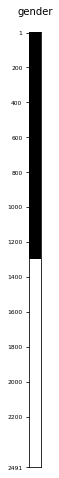

[0 1]


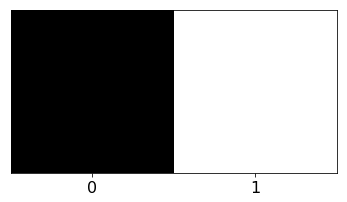

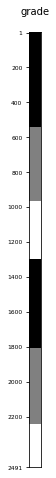

[2 3 4]


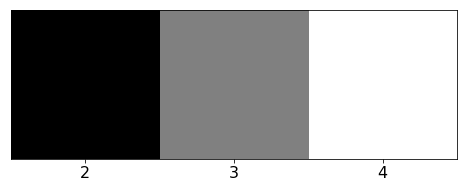

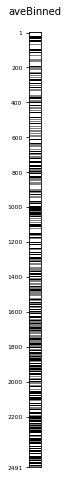

[0 1 2]


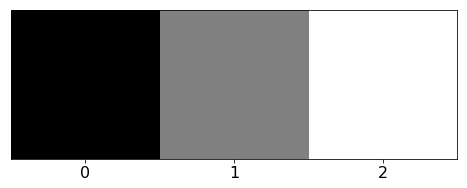

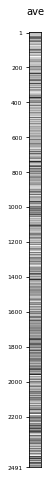

[0 1 2 3 4 5 6]


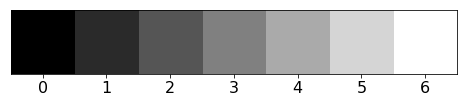

In [84]:
def heatmap_1d(variable):

    width = 64
    g = df[variable].as_matrix()
    # g = np.tile(np.array(g), (256, 1))
    g = np.tile(np.array(g), (width, 1))
    g = g.T
    # print(g.shape)
    
    #fig = plt.figure(figsize=(5, 8))
    fig = plt.figure(figsize=(0.8, 8))
    cmap_reversed = matplotlib.cm.get_cmap('gray')
    plt.imshow(g, cmap=cmap_reversed,  interpolation='nearest')
    plt.title('%s\n' % (variable), fontsize='10')
    #plt.colorbar(ax=ax)
    #m = plt.cm.ScalarMappable(cmap=cmap_reversed)
    #plt.colorbar(m)
    plt.xticks([])
    #ticks = np.linspace(1, df.shape[0], 15)
    ticks = np.append(1, np.arange(200, df.shape[0]-100, 200))
    ticks = np.append(ticks, df.shape[0])
    plt.yticks(ticks, fontsize=6)
    plt.savefig('../manuscript/Figs/heatmap_%s.pdf' % (variable))
    plt.show()

    
def heatmap_1d_cbar(variable):

    if variable != 'ave':
        g = df[variable].as_matrix()
        values = np.unique(g).astype(np.int)
    else:
        values = np.unique([0,1,2,3,4,5,6]).astype(np.int)

    g = values
    print(g)
    g = np.tile(np.array(g), (1,1))
    
    cmap_reversed = matplotlib.cm.get_cmap('gray')
    fig = plt.figure(figsize=(8, 3))
    im = plt.imshow(g, cmap=cmap_reversed,  interpolation='nearest')
    plt.xticks(values - np.min(values), values, fontsize='16')
    plt.yticks([])
    plt.savefig('../manuscript/Figs/heatmap_%s_cmap.pdf' % (variable))
    plt.show()
    

heatmap_1d('gender'); heatmap_1d_cbar('gender')
heatmap_1d('grade'); heatmap_1d_cbar('grade')
heatmap_1d('aveBinned'); heatmap_1d_cbar('aveBinned')
heatmap_1d('ave'); heatmap_1d_cbar('ave')


## **Make pyplot 1D heatmaps for SNAP1,...,SNAP9**

(2491, 576)
[0 1 2]


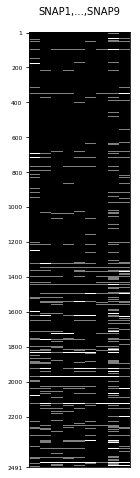

In [89]:

width = 64
gg = np.zeros(shape=(df.shape[0],width*9))
print(gg.shape)
for i in range(9):
    snap = 'SNAP%d'% (i+1)
    g = df[snap].as_matrix()
    g = np.tile(np.array(g), (width, 1))
    g = g.T
    gg[:, i*(width): width*(i+1)]= g

values = np.unique(gg).astype(np.int)
print(values)

#fig = plt.figure(figsize=(5, 8))
fig = plt.figure(figsize=(2, 8))
cmap_reversed = matplotlib.cm.get_cmap('gray')
plt.imshow(gg, cmap=cmap_reversed,  interpolation='nearest')
plt.title('SNAP1,...,SNAP9\n', fontsize='10')
plt.xticks([])
ticks = np.append(1, np.arange(200, df.shape[0]-100, 200))
ticks = np.append(ticks, df.shape[0])
plt.yticks(ticks, fontsize=6)
plt.savefig('../manuscript/Figs/heatmap_SNAP1_SNAP9.pdf')
plt.show()



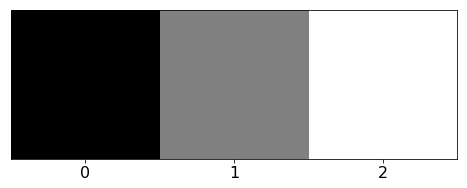

array([0, 1, 2])

In [31]:
g = values
g = np.tile(np.array(g), (1,1))
g = g

fig = plt.figure(figsize=(8, 3))
plt.imshow(g, cmap=cmap_reversed,  interpolation='nearest')
plt.xticks(values, fontsize='16')
plt.yticks([])
plt.savefig('../manuscript/Figs/heatmap_SNAP1_SNAP9_cbar.pdf')
plt.show()
values.T

###  Skip the 'ave' variable and save dataframe df as .csv file

In [32]:
fn_csv = '../data/inattention_nomiss_2491x12.csv'
df['ave'] = ' '
df.drop('ave', axis=1, inplace=True)
print(list(df.columns.values))
print(df.shape)
df.head()

df.to_csv(fn_csv, encoding='utf-8', sep=',', index=False)

['gender', 'grade', 'SNAP1', 'SNAP2', 'SNAP3', 'SNAP4', 'SNAP5', 'SNAP6', 'SNAP7', 'SNAP8', 'SNAP9', 'aveBinned']
(2491, 12)
